In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# ==== Main ======
import os
import pandas as pd
import numpy as np
# ==== display option ===============
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [3]:
# ==== Grafika i wykresy ==================
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

In [4]:
# ==== DATA Preparation =================

from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.base import clone
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from sklearn.metrics import average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import RobustScaler, StandardScaler

In [5]:
# Models

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb 

In [6]:
# Zbiór MNIST 70000 rysunków cyfr
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', cache=True)

In [7]:
X = mnist.data.values
y = mnist.target

In [8]:
X # 70000 obrazków i każdy ma 784 (28 x 28) cechy 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [10]:
y = y.astype(int)

In [11]:
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

In [13]:
some_number = X[69998]

In [14]:
some_number

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [15]:
some_number_image = some_number.reshape(28,28)

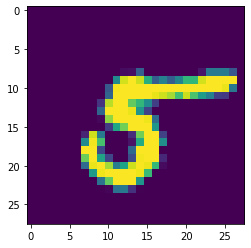

In [16]:
plt.imshow(some_number_image)

In [17]:
y[69998]

5

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [19]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [20]:
# tasowanie danych - 
shuffle_index = np.random.permutation(60000)

In [21]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [22]:
# identyfikowanie binarne np 5 ! dwie klasy: jest 5 = 1; nie - to nie jest 5 = 0 
y_train_5 = np.where(y_train==5, 1, 0)
y_test_5 = np.where(y_test==5, 1, 0)

In [23]:
# wybierzmy jakiś prosty klasyfikator 
from sklearn.linear_model import SGDClassifier

In [24]:
sgd = SGDClassifier(random_state=43)
sgd.fit(X_train,y_train_5)

SGDClassifier(random_state=43)

In [26]:
"to jest 5" if sgd.predict([some_number])[0] == 1 else "to nie jest 5"

'to jest 5'

In [27]:
# ocenimy wydajność - ile % dobrze określił model 

from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96275, 0.964  , 0.9504 ])

### Dokładność powyżej 95% !!! 

Ale czy to dobrze ? 

Bądźmy jak na Titanicu - określmy, że wszyscy umarli ! tzn. napiszmy klasyfikator, który zawsze zwróci nie_5

In [28]:
from sklearn.base import BaseEstimator

In [29]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1))

In [32]:
np.zeros((5,1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

### Jak myślisz jaka będzie dokładność takiego modelu ? 

In [30]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train,y_train_5, cv=3, scoring='accuracy')

array([0.90925, 0.9083 , 0.9114 ])

### Macierz pomyłek 

Znacznie lepszym sposobem oceny jakości klasyfikatora jest macierz pomyłek (confusion matrix)

W celu obliczenia macierzy wpierw trzeba otrzymać prognozy

Rząd reprezentuje rzeczywistą klasę, kolumna przewidywaną klasę. 

In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, X_train,y_train_5, cv=3)

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52978,  1601],
       [  856,  4565]])

Prawidłowo sklasyfikowane = (1,1) (niebędące piątką Prawdziwe Negatywne)

(1,2) = Fałszywie Pozytywne, 

(2,1) = Fałszywie Negatywne, oraz 

(2,2)= Prawdziwie Pozytywne (będące piątkami)   

Gdzie (x,y) oznacza x wiersz y kolumna

(Wyniki mogą być różne ze względu na funkcję zmieniającą indeksy)

$Precyzja = \frac{PP}{PP+FP}$ 

używana wraz z pełnością

$ Pelnosc= \frac{PP}{PP+FN} $, 

czułością lub odsetkiem pozytywnych

In [35]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.7403503081414207

In [38]:
4565/(4565+1601) # nie myli się w % 

0.7403503081414207

In [37]:
recall_score(y_train_5,y_train_pred) 

0.8420955543257701

In [39]:
4565/(4565+856) # rozpoznaje %

0.8420955543257701

## Prawdziwe dane 

Zanonimizowane transakcje kart kredytowych w Europie z 2013 roku. 

Oznakowane jako autentyczne (0) i fraudowe (1) - proces klasyfikacji binarnej




In [40]:
DATA_DIR = 'dane'
DATA_NAME = 'creditcard.csv'

In [41]:
def load_csv_data():
    csv_path = os.path.join(DATA_DIR,DATA_NAME)
    return pd.read_csv(csv_path)

In [42]:
df = load_csv_data()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  100001 non-null  int64  
 1   Time        100001 non-null  float64
 2   V1          100001 non-null  float64
 3   V2          100001 non-null  float64
 4   V3          100001 non-null  float64
 5   V4          100001 non-null  float64
 6   V5          100001 non-null  float64
 7   V6          100001 non-null  float64
 8   V7          100001 non-null  float64
 9   V8          100001 non-null  float64
 10  V9          100001 non-null  float64
 11  V10         100001 non-null  float64
 12  V11         100001 non-null  float64
 13  V12         100001 non-null  float64
 14  V13         100001 non-null  float64
 15  V14         100001 non-null  float64
 16  V15         100001 non-null  float64
 17  V16         100001 non-null  float64
 18  V17         100001 non-null  float64
 19  V1

In [43]:
df['Class'].value_counts()

0    99778
1      223
Name: Class, dtype: int64

Całkowita liczba dodatnich oznakowań, czyli fraudowych transakcji wynosi 223 na 100001 przypadków. 

31 kolumn - 28 numerycznych , Time, Amount (kwota), Class

Uwaga! przypadki fraudow okreslane są równie jako przypadki pozytywne (oznakowane jako 1)

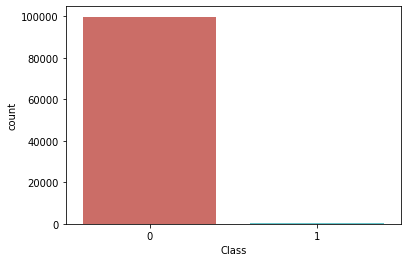

In [44]:
sns.countplot(x='Class',data=df, palette='hls')
plt.show()

In [46]:
df.head()
# brak standaryzacji zmiennych numerycznych

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [47]:
df.sample(5)

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
94049,94049,64707.0,-1.310030,0.905399,1.676835,0.187526,-0.130145,-0.699455,0.392658,0.209299,-0.040024,-0.437564,-0.913352,-0.036428,-0.517616,-0.030104,-0.283057,-0.372059,0.181428,-0.481339,0.445449,0.061615,-0.219781,-0.461781,-0.310376,0.419930,0.385706,0.279435,-0.146993,-0.201784,6.42,0
24656,24656,33318.0,1.211530,0.413658,0.716049,2.318168,-0.094362,0.174045,-0.231148,0.038505,-0.409832,0.669016,-1.335354,-0.356682,0.369538,0.000318,0.814106,1.173487,-1.069652,0.361010,-0.906826,-0.093701,0.090447,0.248176,-0.168036,-0.452614,0.548669,0.148489,0.011409,0.022478,10.62,0
38361,38361,39365.0,1.241609,-0.568616,0.962068,0.611091,-0.989857,0.392818,-0.856996,0.058006,-0.345424,0.612136,-1.586496,0.497886,1.628616,-0.785637,-0.073432,-1.189238,-0.375417,1.413465,-0.731566,-0.359098,-0.442806,-0.636008,-0.073001,-0.469089,0.433448,-0.347277,0.095870,0.044087,49.98,0
2584,2584,2113.0,-2.746065,3.022169,-0.134017,-0.386662,-0.244242,0.742847,-1.653331,-6.059684,0.366991,0.348124,-1.057279,0.239140,0.155290,-0.231601,0.821355,0.690427,0.266973,0.237189,0.065207,-1.072000,5.752131,-2.935378,0.817265,-0.638756,0.153555,0.152716,0.342278,-0.076196,9.87,0
81139,81139,58803.0,1.020932,-0.018881,1.148134,1.194908,-0.797047,-0.239884,-0.346465,0.054538,0.305389,-0.135902,0.219138,0.767607,0.727769,-0.024910,1.527264,0.146412,-0.289528,-0.441413,-1.069932,-0.013746,0.106690,0.281139,0.041791,0.398073,0.217779,-0.446904,0.067068,0.049265,59.13,0


In [48]:
df.columns

Index(['Unnamed: 0', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount', 'Class'],
      dtype='object')

In [58]:
# obsługa wartości nienumerycznych NaN - not a number
nanCounter = np.isnan(df).sum()
nanCounter

Unnamed: 0    0
Time          0
V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
Amount        0
Class         0
dtype: int64

In [59]:
distinctCounter = df.apply(lambda x: len(x.unique()))
distinctCounter 

Unnamed: 0    100001
Time           45547
V1             97501
V2             97501
V3             97501
V4             97501
V5             97501
V6             97501
V7             97501
V8             97501
V9             97501
V10            97501
V11            97501
V12            97501
V13            97501
V14            97501
V15            97501
V16            97501
V17            97501
V18            97501
V19            97501
V20            97501
V21            97501
V22            97501
V23            97501
V24            97501
V25            97501
V26            97501
V27            97501
V28            97501
Amount         19768
Class              2
dtype: int64

In [50]:
target = df['Class']

df2 = df.copy()

df2 = df2.drop(columns=['Time'])
df2 = df2.drop(columns=['Class','Unnamed: 0']) # macierz X

In [51]:
df2.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000,100001.000000
mean,-0.262182,-0.032294,0.676205,0.162566,-0.278488,0.094099,-0.108711,0.056020,-0.046474,-0.023088,0.250237,-0.066028,0.007593,0.059912,0.192995,-0.007712,0.058048,-0.092294,-0.021986,0.044609,-0.030861,-0.109102,-0.037023,0.008978,0.132205,0.026659,0.000628,0.001738,97.960297
std,1.859217,1.656978,1.322925,1.349263,1.356392,1.301385,1.210913,1.207520,1.121390,1.070855,1.067023,1.112746,1.037955,0.965546,0.929697,0.898753,0.942828,0.846054,0.817317,0.759536,0.718888,0.634314,0.632905,0.595271,0.441078,0.494537,0.393742,0.325161,264.621869
min,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,-18.271168,-4.049895,-17.769143,-5.791881,-19.214325,-4.152532,-13.563273,-25.162799,-9.498746,-7.213527,-21.024817,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000
25%,-1.028110,-0.598683,0.176739,-0.711504,-0.898663,-0.647789,-0.600200,-0.137454,-0.698812,-0.496338,-0.524066,-0.482951,-0.678242,-0.332673,-0.358108,-0.481345,-0.401051,-0.561829,-0.516034,-0.169245,-0.224510,-0.531336,-0.176415,-0.323713,-0.131782,-0.325102,-0.062533,-0.005355,7.570000
50%,-0.260559,0.078317,0.753962,0.192532,-0.314370,-0.157006,-0.069107,0.074142,-0.119105,-0.094912,0.180619,0.113271,-0.007854,0.077858,0.299874,0.066700,-0.001101,-0.086530,-0.026019,-0.024568,-0.057669,-0.083875,-0.049237,0.064999,0.170104,-0.070320,0.009834,0.023318,26.310000
75%,1.153321,0.735885,1.376306,1.032416,0.249744,0.486361,0.414657,0.360521,0.558309,0.439030,1.065090,0.623731,0.684385,0.491215,0.864868,0.537354,0.455840,0.388227,0.480136,0.170600,0.119198,0.308337,0.081523,0.406282,0.419920,0.300666,0.083028,0.076573,89.000000
max,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,13.249433,12.018913,7.848392,4.465413,10.526766,5.784514,6.098529,9.253526,5.041069,5.228342,39.420904,22.614889,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,19656.530000


In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      100001 non-null  float64
 1   V2      100001 non-null  float64
 2   V3      100001 non-null  float64
 3   V4      100001 non-null  float64
 4   V5      100001 non-null  float64
 5   V6      100001 non-null  float64
 6   V7      100001 non-null  float64
 7   V8      100001 non-null  float64
 8   V9      100001 non-null  float64
 9   V10     100001 non-null  float64
 10  V11     100001 non-null  float64
 11  V12     100001 non-null  float64
 12  V13     100001 non-null  float64
 13  V14     100001 non-null  float64
 14  V15     100001 non-null  float64
 15  V16     100001 non-null  float64
 16  V17     100001 non-null  float64
 17  V18     100001 non-null  float64
 18  V19     100001 non-null  float64
 19  V20     100001 non-null  float64
 20  V21     100001 non-null  float64
 21  V22     10

In [53]:
distinctCounter = df2.apply(lambda x: len(x.unique()))

In [54]:
distinctCounter

V1        97501
V2        97501
V3        97501
V4        97501
V5        97501
V6        97501
V7        97501
V8        97501
V9        97501
V10       97501
V11       97501
V12       97501
V13       97501
V14       97501
V15       97501
V16       97501
V17       97501
V18       97501
V19       97501
V20       97501
V21       97501
V22       97501
V23       97501
V24       97501
V25       97501
V26       97501
V27       97501
V28       97501
Amount    19768
dtype: int64

In [55]:
df2.dtypes.value_counts()

float64    29
dtype: int64

In [56]:
df2.isnull().any().any()

False

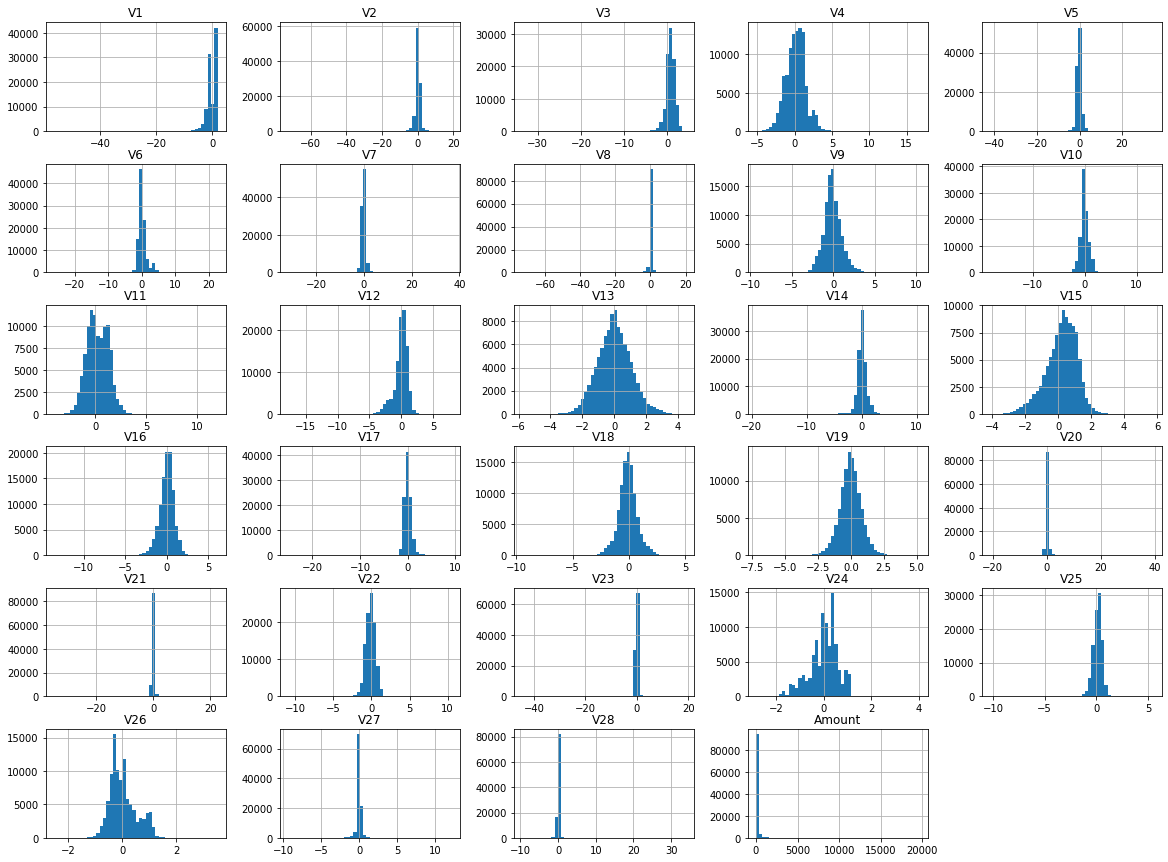

In [60]:
df2.hist(bins=50,figsize=(20,15))
plt.show()

<AxesSubplot:>

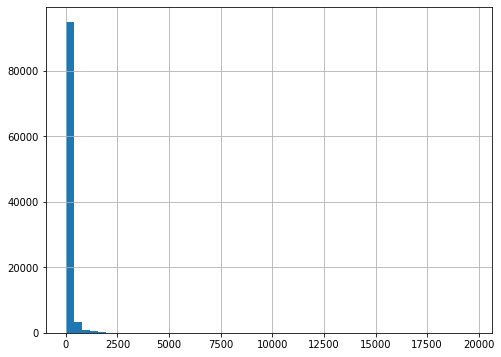

In [61]:
### EDA

df['Amount'].hist(bins=50,figsize=(8,6))

<AxesSubplot:>

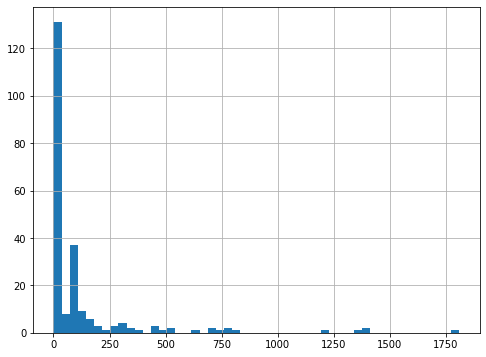

In [62]:
df[df['Class']==1]['Amount'].hist(bins=50,figsize=(8,6))

In [76]:
df2c = df.copy()

df2c = df2c.drop(columns=['Time','Unnamed: 0'])

corr_matrix = df2c.corr()

In [77]:
corr_matrix['Class'].sort_values(ascending=False)

Class     1.000000
V11       0.185601
V4        0.166203
V2        0.118394
V8        0.104108
V27       0.062664
V21       0.049098
V19       0.047277
V20       0.019040
V25       0.007828
V26       0.007666
V28       0.005399
Amount    0.003253
V15       0.002281
V13      -0.000782
V22      -0.001041
V24      -0.009129
V23      -0.016656
V6       -0.068307
V9       -0.119891
V5       -0.142983
V1       -0.146549
V18      -0.160144
V7       -0.240844
V16      -0.252847
V10      -0.270631
V12      -0.296582
V3       -0.306701
V14      -0.373653
V17      -0.413776
Name: Class, dtype: float64

<AxesSubplot:>

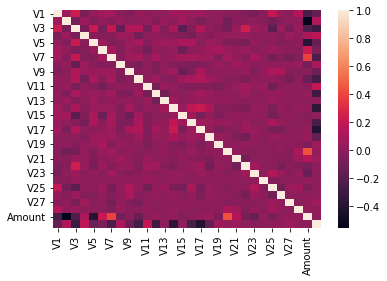

In [78]:
sns.heatmap(corr_matrix)

In [63]:
zmienneDoStandaryzacji = df2.columns
sX = StandardScaler(copy=True)
df_s = sX.fit_transform(df[zmienneDoStandaryzacji])


In [65]:
df_st = pd.DataFrame(df_s, columns=zmienneDoStandaryzacji)

In [67]:
df_st.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
99996,0.497334,-0.787139,0.087202,0.195022,-0.820923,0.039475,-0.303856,0.121857,1.271355,-0.517697,-0.987340,0.005958,-1.330759,-0.263314,-0.064743,-0.340606,0.478749,-0.914549,0.067330,0.381887,-0.045743,-0.693166,-0.105460,0.214540,-0.478694,1.864219,-0.193618,0.159361,0.649495
99997,-2.510650,-0.638769,-0.285859,1.280674,-0.574762,-0.325358,-1.147542,1.403116,-0.248654,-0.882345,-1.074101,1.096688,1.053755,0.762888,1.072720,0.336259,0.743516,-0.002448,0.256544,-1.007647,0.114940,0.434052,-0.865825,0.353221,0.112744,-0.565897,0.287429,-3.213969,-0.200137
99998,0.669210,-0.077691,-0.107282,0.409109,0.285577,0.815000,-0.157006,0.299163,0.369870,-0.357113,0.372315,1.087518,0.172401,-0.056574,0.673242,-1.835701,1.354417,-3.204158,-1.764806,-0.324337,-0.060321,0.310828,0.308510,-0.990956,-0.072781,0.701798,0.119835,0.012929,-0.264833
99999,-4.369457,4.053599,-2.604220,-1.752084,-0.654130,-0.045219,0.097096,0.766939,5.100251,9.236797,0.784442,0.530020,-0.142695,-1.977682,0.910210,-0.204819,-1.133203,-0.371254,-0.621685,5.125477,-1.798596,-1.675602,0.430174,-2.204113,2.863392,0.200386,4.718667,1.790680,-0.329530
100000,-0.262628,0.765317,-0.893961,-1.008963,1.990398,2.560514,-0.033500,0.087255,-0.179501,-0.044117,-0.230922,-0.177078,-0.105989,-0.374726,0.970842,0.788984,-0.515760,0.490151,0.315492,0.190632,0.618582,-1.859250,0.175757,1.525687,-0.155059,0.146152,0.986679,0.482611,-0.349445


In [71]:
correlationM = pd.DataFrame(data=[], index=df_st.columns, columns=df_st.columns)

for i in df_st.columns:
    for j in df_st.columns:
        correlationM.loc[i,j] = np.round(pearsonr(df_st.loc[:, i],df_st.loc[:,j])[0],2)

In [72]:
correlationM

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
V1,1.0,0.06,0.22,-0.07,0.02,0.07,0.08,-0.02,-0.05,0.02,-0.0,0.0,0.0,0.07,0.05,0.04,0.06,0.0,-0.0,-0.03,-0.02,-0.06,-0.08,-0.01,0.19,0.02,-0.03,0.14,-0.25
V2,0.06,1.0,-0.08,0.05,-0.05,0.02,-0.03,0.03,-0.01,0.01,0.03,-0.05,0.04,-0.02,0.06,0.0,-0.07,-0.02,0.01,-0.1,-0.02,-0.02,0.0,-0.02,-0.09,-0.03,0.01,0.01,-0.56
V3,0.22,-0.08,1.0,-0.09,0.21,-0.07,0.2,-0.15,0.12,0.13,-0.08,0.09,-0.04,0.1,-0.18,-0.05,0.11,0.0,-0.04,-0.09,0.04,0.23,0.05,0.02,-0.19,0.04,-0.08,0.03,-0.23
V4,-0.07,0.05,-0.09,1.0,-0.01,-0.04,-0.03,0.05,0.04,-0.09,0.01,0.01,-0.01,-0.02,-0.05,-0.09,-0.0,-0.04,0.01,0.02,0.02,0.04,-0.01,-0.0,-0.0,-0.02,0.05,-0.0,0.09
V5,0.02,-0.05,0.21,-0.01,1.0,0.04,-0.05,-0.03,0.04,0.09,-0.03,0.03,0.05,0.04,0.1,0.11,-0.02,0.05,0.02,-0.05,-0.05,-0.08,0.02,-0.02,-0.01,-0.04,-0.03,0.0,-0.4
V6,0.07,0.02,-0.07,-0.04,0.04,1.0,0.07,-0.04,0.04,-0.01,-0.09,0.02,-0.01,0.03,-0.12,-0.02,0.01,0.05,0.09,0.04,0.01,0.04,-0.02,-0.0,0.05,0.0,-0.01,-0.01,0.21
V7,0.08,-0.03,0.2,-0.03,-0.05,0.07,1.0,-0.03,0.05,0.07,-0.02,0.08,0.01,0.04,0.08,0.09,0.05,0.05,-0.04,0.07,0.02,-0.04,0.08,0.0,-0.09,-0.04,-0.1,-0.04,0.39
V8,-0.02,0.03,-0.15,0.05,-0.03,-0.04,-0.03,1.0,-0.03,-0.07,0.0,-0.05,-0.0,-0.04,-0.04,-0.06,-0.05,-0.02,0.03,-0.01,0.05,0.02,-0.01,0.0,0.01,0.01,0.01,0.03,-0.1
V9,-0.05,-0.01,0.12,0.04,0.04,0.04,0.05,-0.03,1.0,-0.03,0.0,-0.06,0.02,0.07,-0.13,-0.05,0.11,-0.01,0.01,0.01,-0.0,0.04,-0.05,0.01,0.12,0.11,-0.04,-0.02,-0.02
V10,0.02,0.01,0.13,-0.09,0.09,-0.01,0.07,-0.07,-0.03,1.0,-0.0,0.05,-0.03,-0.03,0.06,0.09,0.12,0.06,-0.0,-0.03,-0.02,-0.05,-0.01,0.0,0.01,-0.02,-0.08,-0.02,-0.14


In [ ]:
!pip install Advanced-scorecard-builder

In [ ]:
from AmaFree import AdvancedScorecardBuilder as asb

In [ ]:
X = df2
t = asb(X,'Class')

In [ ]:
t.fit()

In [ ]:
t.get_scorecard()

In [ ]:
t.model_info_

In [ ]:
t.html_report('raport.html')

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df_st, target, test_size=0.33, random_state=2022, stratify=target)

## jaką funkcję kosztu proponujessz ?? 


funkcja zaniku logarytmicznego dla klasyfikcji binarnej (entropia krzyzowa miedzy estymatorem a prawdziwą wartością)

 $log\,loss = \frac{-1}{N}\sum_{i=1}^{N}\sum_{j=1}^{M} y_{i,j}\log(p_{i,j}) $

 $M=2$ - ilośc klas

 $y_{i,j}$ - $y_i$ w klasie $j$

In [81]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

In [82]:
# logistic regresion
penalty = 'l2' # mniej czułe na elementy odstające ni l1 - realizue stabilniejsze rozwiazanie
C = 1.0 # siła regularyzacji - im mniejsza C tym silniejsza regularyzacja
class_weight = 'balanced' # 
random_state = 2022
solver = 'liblinear'
logReg = LogisticRegression(penalty=penalty,
C=C, class_weight=class_weight, random_state=random_state,
solver=solver, n_jobs=-1)

In [84]:
trainingScores = []
cvScores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index , columns=[0,1])

model=logReg

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    print('log loss on Train:', loglossTraining)
    print('CV log loss:' ,loglossCV)

# na calym zestawie uczacym 
loglossLogisticRegression = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression log loss: ', loglossLogisticRegression )



log loss on Train: 0.09903224474090869
CV log loss: 0.10079589127618974
log loss on Train: 0.10608351343106784
CV log loss: 0.11471661380723781
log loss on Train: 0.12480513051649363
CV log loss: 0.11203430262572418
log loss on Train: 0.11192258313882579
CV log loss: 0.126252409444034
log loss on Train: 0.09723872634942064
CV log loss: 0.09224922852562825
Logistic Regression log loss:  0.10920968913576279


Text(0.5, 1.0, 'Precision-Recall curve: AVG P = 0.62')

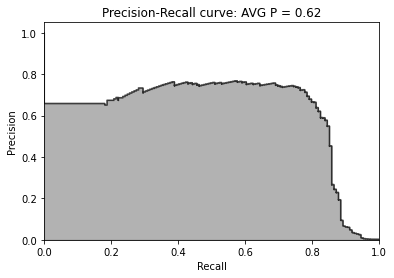

In [88]:
preds = pd.concat([y_train, predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogRegresion = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k',alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])
plt.title('Precision-Recall curve: AVG P = {0:0.2f}'.format(average_precision))


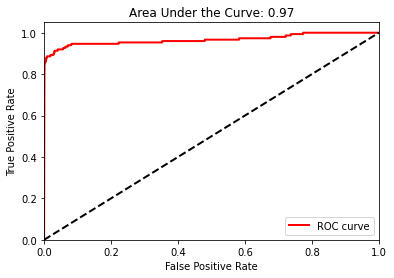

In [89]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr, color='r', lw=2, label="ROC curve")
plt.plot([0,1],[0,1], color='k', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under the Curve: {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [92]:
predTestSetLogReg = pd.DataFrame(data=[], index=y_test.index, columns=['prediction'])
predTestSetLogReg.loc[:, 'prediction']=logReg.predict_proba(X_test)[:,1]
loglossTestSetLogReg = log_loss(y_test,predTestSetLogReg )
print(f"Log Loss of Log Reg on Test Set: {loglossTestSetLogReg}")

Log Loss of Log Reg on Test Set: 0.09538426983066753


In [93]:
#zadanie 

params_lightGB = {
    'task': 'train',
    'application': 'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth': 4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction':1.0,
    'bagging_fraction':1.0,
    'bagging_freq': 0,
    'bagging_seed': 2022,
    'num_threads': 16
}

In [101]:
trainingScores = []
cvScores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index , columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=200)
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    print('log loss on Train:', loglossTraining)
    print('CV log loss:' ,loglossCV)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 120, number of negative: 53480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 53600, number of used features: 29
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002239 -> initscore=-6.099571
[LightGBM] [Info] Start training from score -6.099571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.00929988
Training until validation scores don't improve 

In [102]:
loglossGBM = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('Logistic Regression log loss: ', loglossGBM )

Logistic Regression log loss:  0.0032232072862504457


Text(0.5, 1.0, 'Precision-Recall curve: AVG P = 0.84')

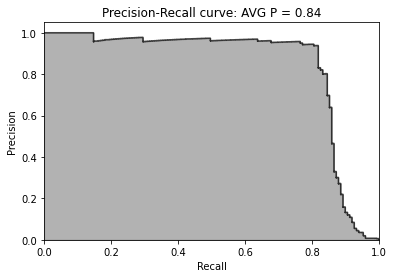

In [104]:
preds = pd.concat([y_train, predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogRegresion = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k',alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])
plt.title('Precision-Recall curve: AVG P = {0:0.2f}'.format(average_precision))


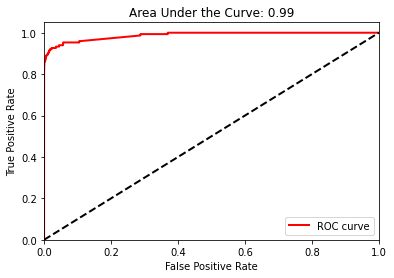

In [105]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr, color='r', lw=2, label="ROC curve")
plt.plot([0,1],[0,1], color='k', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under the Curve: {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [106]:
predTestSetGBM = pd.DataFrame(data=[], index=y_test.index, columns=['prediction'])
predTestSetGBM.loc[:, 'prediction']=gbm.predict(X_test)
loglossTestSetGBM = log_loss(y_test,predTestSetGBM )
print(f"Log Loss of Log Reg on Test Set: {loglossTestSetGBM}")

Log Loss of Log Reg on Test Set: 0.0019448771890388297
